# Question 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

## How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jacfwd

In [64]:
# Code!

# Function to draw the pose graph
def draw(X, Y, title):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'bo')
    plt.plot(X, Y, 'g-')
    
    plt.plot([X[0], X[-1]], [Y[0], Y[-1]], 'r-')

    plt.title(title)
    plt.show()
    

# Function to compute frobenius norm
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")
    
    
def linear_motion_model(x, u):
    return x + u

def get_data():
    u = jnp.array([1.1, 1.0, 1.1, -2.7, 0.0])
    x = jnp.zeros(5)

    for i in range(1, 5):
        x = x.at[i].set(linear_motion_model(x[i-1], u[i-1]))
    
    return x, u

x, u = get_data()
print("Poses:", x)
print("Control inputs:", u)

Poses: [0.         1.1        2.1        3.1999998  0.49999976]
Control inputs: [ 1.1  1.   1.1 -2.7  0. ]


In [65]:
def residual(x, u):
    d = x.shape[0]
    res = jnp.zeros(d+1)
    for i in range(1, d):
        res = res.at[i-1].set(x[i-1] + u[i-1] - x[i])
        
    res = res.at[d-1].set(linear_motion_model(x[0], u[d-1]) - x[d-1])
    res = res.at[d].set(x[0])
    
    return res

def check_conv(x,x1,threshold):
    d=len(x)
    flag=bool(1)
    for i in range(0,d):
        val=(abs(x1[i]-x[i])<threshold)
        flag=(flag and val)
    return flag

def SLAM_1D(x_in, u_in, max_iters, thresh):
    # Computing Jacobian using jax
    f = lambda a: residual(a, u_in)
    J = jacfwd(f)
    
    # Information matrix
    info_mat = jnp.identity(6)*0.01
    info_mat = info_mat.at[5, 5].set(0.001)
    info_mat = jnp.linalg.inv(info_mat)
    
    x = x_in
    for i in range(max_iters):
        print("Iteration %d" % (i+1))
        print("Pose:", x)
        
        J_jax = J(x)
        J_man = jnp.array([
            [1, -1, 0, 0, 0],
            [0, 1, -1, 0, 0],
            [0, 0, 1, -1, 0],
            [0, 0, 0, 1, -1],
            [1, 0, 0, 0, -1],
            [1, 0, 0, 0, 0]
        ])
        
        # Frobenius norm between jacobians computed above
        frobNorm(J_jax, J_man, "jax jacobian", "analytical jacobian")

        H = J_man.T @ info_mat @ J_man
        b = J_man.T @ info_mat.T @ f(x)
        
        dx = -jnp.linalg.inv(H) @ b
        x_tmp = x + dx
        print("Update step:", dx)
        print("Updated pose:", x_tmp)
        
        cost = (f(x).T @ info_mat @ f(x))/2
        print("Error: %.3f\n" % cost)
        
        draw(x, x, "Iteration %d" % (i+1))
        
        if jnp.linalg.norm(x_tmp - x) < thresh:
            print("SLAM converged at iteration", i)
            break
            
        x = x_tmp
        
    draw(x, x, "Final optimized pose graph")
        
    return x

#### Threshold 1e-5

Initial poses: [0.         1.1        2.1        3.1999998  0.49999976]
Control inputs: [ 1.1  1.   1.1 -2.7  0. ] 

Iteration 1
Pose: [0.         1.1        2.1        3.1999998  0.49999976]
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Update step: [-0.         -0.09999996 -0.19999994 -0.2999999  -0.39999983]
Updated pose: [-0.          1.0000001   1.9         2.8999999   0.09999993]
Error: 12.500



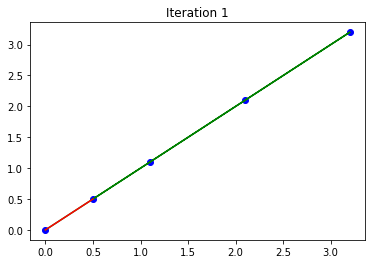

Iteration 2
Pose: [-0.          1.0000001   1.9         2.8999999   0.09999993]
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Update step: [ 0.         -0.00000007 -0.00000003  0.00000014  0.00000004]
Updated pose: [-0.          1.          1.9         2.9         0.09999998]
Error: 2.500



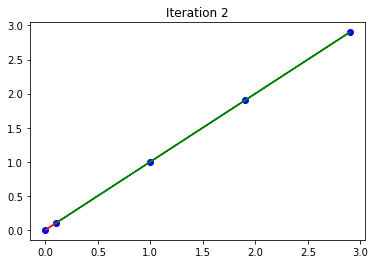

SLAM converged at iteration 1


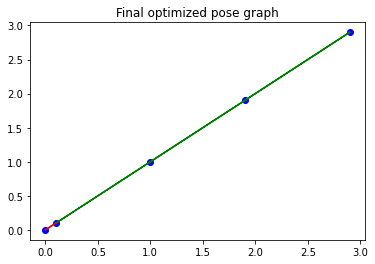


Optimal poses:
 [-0.          1.0000001   1.9         2.8999999   0.09999993]


In [66]:
x, u = get_data()
print("Initial poses:", x)
print("Control inputs:", u, "\n")

x_opt = SLAM_1D(x, u, 100, 1e-5)
print("\nOptimal poses:\n", x_opt)

#### Threshold 1e-10

Initial poses: [0.         1.1        2.1        3.1999998  0.49999976]
Control inputs: [ 1.1  1.   1.1 -2.7  0. ] 

Iteration 1
Pose: [0.         1.1        2.1        3.1999998  0.49999976]
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Update step: [-0.         -0.09999996 -0.19999994 -0.2999999  -0.39999983]
Updated pose: [-0.          1.0000001   1.9         2.8999999   0.09999993]
Error: 12.500



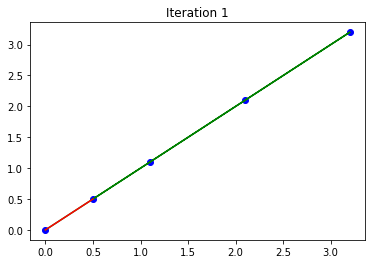

Iteration 2
Pose: [-0.          1.0000001   1.9         2.8999999   0.09999993]
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Update step: [ 0.         -0.00000007 -0.00000003  0.00000014  0.00000004]
Updated pose: [-0.          1.          1.9         2.9         0.09999998]
Error: 2.500



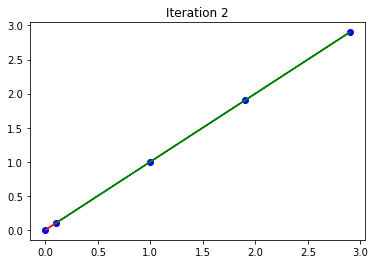

Iteration 3
Pose: [-0.          1.          1.9         2.9         0.09999998]
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Update step: [-0.          0.00000002  0.00000004 -0.00000005  0.00000002]
Updated pose: [-0.          1.          1.9         2.9         0.09999999]
Error: 2.500



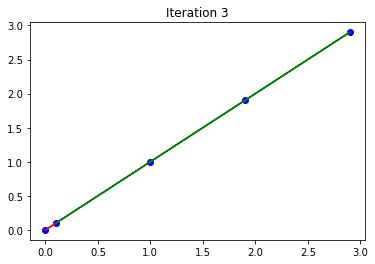

Iteration 4
Pose: [-0.          1.          1.9         2.9         0.09999999]
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Update step: [ 0.          0.00000002  0.00000004 -0.00000005  0.00000001]
Updated pose: [-0.   1.   1.9  2.9  0.1]
Error: 2.500



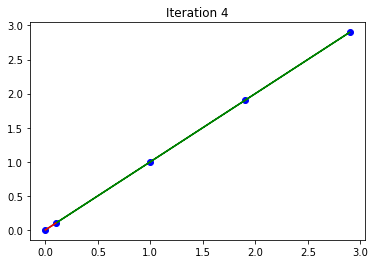

Iteration 5
Pose: [-0.   1.   1.9  2.9  0.1]
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Update step: [-0.          0.00000002  0.00000004 -0.00000005 -0.        ]
Updated pose: [-0.   1.   1.9  2.9  0.1]
Error: 2.500



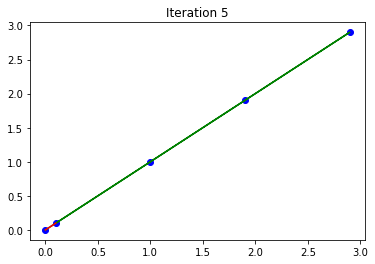

Iteration 6
Pose: [-0.   1.   1.9  2.9  0.1]
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Update step: [-0.          0.00000002  0.00000004 -0.00000005 -0.        ]
Updated pose: [-0.   1.   1.9  2.9  0.1]
Error: 2.500



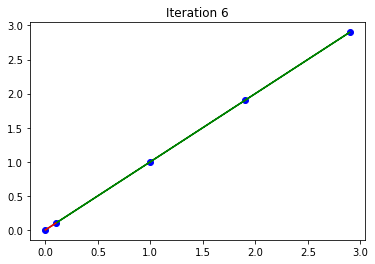

SLAM converged at iteration 5


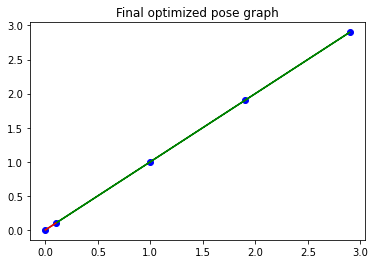


Optimal poses:
 [-0.   1.   1.9  2.9  0.1]


In [67]:
x, u = get_data()
print("Initial poses:", x)
print("Control inputs:", u, "\n")

x_opt = SLAM_1D(x, u, 100, 1e-10)
print("\nOptimal poses:\n", x_opt)

We see that the poses/vertices 1 and 5, which were supposed to be the same vertice (loop closure) are almost close to each other. Initially the distance between the pose 1 and pose 5 was 0.5. And at the end of algorithm convergence, the distance between them is ~0.1. However, we see that the algorithm converged in 1 iteration only in the previous experiment. However decreasing threshold from 1e-5 to 1e-10 increased the number of iterations to 5. THe early convergence is due to 1D nature of the problem and the lesser number of poses and control inputs. As the number of poses are less the residual size is also less and hence, the optimization was quick. On the other hand, if there were large number of poses, the optimization algorithm could have taken more iterations to converge.